In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os,itertools
from scipy.interpolate import griddata
import os,glob,imp,copy
import numpy as np
import seaborn as sns
import pyslha, copy, pickle
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/3780856860.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import os,glob,imp,copy


In [2]:
def getContour(xpts,ypts,zpts,levels,ylog=False,xlog=False):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    
    #Use log scale:
    if ylog:
        y = np.log10(y)
    if xlog:
        x = np.log10(x)
    
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    #scale back:
    if ylog or xlog:
        for key,ptsList in levelPts.items():
            newList = []
            for pts in ptsList:
                xpts = pts[:,0]
                ypts = pts[:,1]
                if xlog:
                    xpts = 10**xpts
                if ylog:
                    ypts = 10**ypts
                newList.append(np.column_stack((xpts,ypts)))
            levelPts[key] = newList
        
    
    return levelPts

In [3]:
def interpolateData(x,y,z,nx=200,ny=200,method='linear',fill_value=np.nan,xnew=None,ynew=None):

    if x.min() == x.max() or y.min() == y.max(): # Can not interpolate
        return None,None,None
    elif xnew is None or ynew is None:
        xnew = np.linspace(x.min(),x.max(),nx)
        ynew = np.linspace(y.min(),y.max(),ny)

    xi = np.array([list(v) for v in itertools.product(xnew,ynew)])
    znew = griddata(list(zip(x,y)),z,xi=xi, 
                    method=method,fill_value=fill_value)
    znew = np.reshape(znew,(len(xnew),len(ynew)))
    xnew,ynew  = np.meshgrid(xnew,ynew,indexing='ij')

    return xnew,ynew,znew

In [4]:
# TDTM1F : C1C1

readSummary = True # whether to read SModelS results or load stored data

# Read SModelS summary
if readSummary:
    df_C1C1 = pd.read_csv('TDTM1F_summary.txt'
                     ,skiprows=3,sep='\\s+')
    condition = df_C1C1['r_max'].notna()
    df_C1C1 = df_C1C1[condition]
    
    # Add model data
    slha_dir_C1C1 = '/Users/altakach/SModelS3/smodels/run-dir-validation-ATLAS-SUSY-18-42-TDTM1F/slha/'
    modelData_C1C1 = []
    for f in df_C1C1['#filename']:
        data_C1C1 = pyslha.readSLHAFile(os.path.join(slha_dir_C1C1,f))
        mC1 = abs(data_C1C1.blocks['MASS'][1000024])
        mN1 = abs(data_C1C1.blocks['MASS'][1000022])
        width_C1 = data_C1C1.decays[1000024].totalwidth
        modelData_C1C1.append([mC1,mN1,width_C1])
    modelData_C1C1 = np.array(modelData_C1C1)
    df_C1C1[['mC1','mN1','wC1']] = modelData_C1C1
    df_C1C1['#filename'] = df_C1C1['#filename'].str.replace('-Original', '')
    df_C1C1 = df_C1C1.reset_index(drop=True)
    # Save to CSV
    df_C1C1.to_csv('validation_data_TDTM1F.csv')
else:
    # Read stored results
    df_C1C1 = pd.read_csv('validation_data_TDTM1F.csv')


In [5]:
# TDTM2F : C1N1

readSummary = True # whether to read SModelS results or load stored data

# Read SModelS summary
if readSummary:
    df_C1N1 = pd.read_csv('TDTM2F_summary.txt'''
                     ,skiprows=3,sep='\\s+')
    condition = df_C1N1['r_max'].notna()
    df_C1N1 = df_C1N1[condition]
    
    # Add model data
    slha_dir_C1N1 = '/Users/altakach/SModelS3/smodels/run-dir-validation-ATLAS-SUSY-18-42-TDTM2F/slha/'
    modelData_C1N1 = []
    for f in df_C1N1['#filename']:
        data_C1N1 = pyslha.readSLHAFile(os.path.join(slha_dir_C1N1,f))
        mC1 = abs(data_C1N1.blocks['MASS'][1000024])
        mN1 = abs(data_C1N1.blocks['MASS'][1000022])
        width_C1 = data_C1N1.decays[1000024].totalwidth
        modelData_C1N1.append([mC1,mN1,width_C1])
    modelData_C1N1 = np.array(modelData_C1N1)
    df_C1N1[['mC1','mN1','wC1']] = modelData_C1N1
    # Remove '-Original' from the '#filename' column
    df_C1N1 = df_C1N1.reset_index(drop=True)
    # Save to CSV
    df_C1N1.to_csv('validation_data_TDTM2F.csv')
else:
    # Read stored results
    df_C1N1 = pd.read_csv('validation_data_TDTM2F.csv')


In [6]:

x_C1C1,y_C1C1 = df_C1C1['mC1'], 6.582e-25 / (df_C1C1['wC1']*10**-9)
rValues_C1C1 = df_C1C1['r_max']
nx_C1C1 = len(x_C1C1)
ny_C1C1 = len(y_C1C1)

print(nx_C1C1)
print(ny_C1C1)

xnew_C1C1,ynew_C1C1,znew_C1C1 = interpolateData(x_C1C1,y_C1C1,rValues_C1C1,nx=nx_C1C1,ny=ny_C1C1,fill_value=0.0)
excCurve_C1C1 = getContour(x_C1C1,y_C1C1,rValues_C1C1,levels=[1.0],ylog=True)
print(excCurve_C1C1)

x_C1N1,y_C1N1 = df_C1N1['mC1'], 6.582e-25 / (df_C1N1['wC1']*10**-9)
rValues_C1N1 = df_C1N1['r_max']
nx_C1N1 = len(x_C1N1)
ny_C1N1 = len(y_C1N1)

print(nx_C1N1)
print(ny_C1N1)

xnew_C1N1,ynew_C1N1,znew_C1N1 = interpolateData(x_C1N1,y_C1N1,rValues_C1N1,nx=nx_C1N1,ny=ny_C1N1,fill_value=0.0)
excCurve_C1N1 = getContour(x_C1N1,y_C1N1,rValues_C1N1,levels=[1.0],ylog=True)
print(excCurve_C1N1)

882
882
{1.0: [array([[438.26530612,   1.        ],
       [448.60097324,   1.01433627],
       [450.        ,   1.02103807],
       [453.10810811,   1.03212897],
       [475.        ,   1.07170125],
       [491.12261146,   1.09452833],
       [500.        ,   1.09949919],
       [513.02570093,   1.14171415],
       [525.        ,   1.16726229],
       [534.18458781,   1.17458495],
       [550.        ,   1.23962607],
       [553.64758698,   1.24265646],
       [565.625     ,   1.28964113],
       [575.        ,   1.32357189],
       [582.01438849,   1.28964113],
       [594.79708637,   1.2231465 ],
       [600.        ,   1.20236598],
       [606.16522811,   1.21122895],
       [623.58490566,   1.28964113],
       [625.        ,   1.29618545],
       [644.15829146,   1.37117798],
       [650.        ,   1.42021205],
       [666.25874126,   1.52957894],
       [675.        ,   1.5759368 ],
       [680.44662309,   1.58339026],
       [700.        ,   1.64295181],
       [701.51515152,  

In [7]:
sorted_df_C1C1 = df_C1C1.sort_values(by='#filename')
sorted_df_C1N1 = df_C1N1.sort_values(by='#filename')

# Remove '-Original' from the '#filename' column
#sorted_df_C1C1['#filename'] = sorted_df_C1C1['#filename'].str.replace('-Original', '')


# Find common values in the specified column
common_values = set(sorted_df_C1C1['#filename']).intersection(set(sorted_df_C1N1['#filename']))

# Filter both DataFrames to keep only the rows with common values
df_C1C1_filtered = sorted_df_C1C1[sorted_df_C1C1['#filename'].isin(common_values)]
df_C1N1_filtered = sorted_df_C1N1[sorted_df_C1N1['#filename'].isin(common_values)]

df_C1C1_filtered = df_C1C1_filtered.reset_index(drop=True)
df_C1N1_filtered = df_C1N1_filtered.reset_index(drop=True)

# save the data frames inro csv files
df_C1C1_filtered.to_csv('filtered_validation_data_TDTM1F.csv')
df_C1N1_filtered.to_csv('filtered_validation_data_TDTM2F.csv')

# combine C1N1 and C1C1 results
df_Comb = df_C1C1_filtered.copy()
df_Comb['r_max'] = df_C1C1_filtered['r_max'] + df_C1N1_filtered['r_max']
df_Comb['r_exp'] = df_C1C1_filtered['r_exp'] + df_C1N1_filtered['r_exp']
df_Comb['r(ATLAS)'] = df_C1C1_filtered['r(ATLAS)'] + df_C1N1_filtered['r(ATLAS)']
df_Comb['r_exp(ATLAS)'] = df_C1C1_filtered['r_exp(ATLAS)'] + df_C1N1_filtered['r_exp(ATLAS)']

# save the data frames inro csv files
df_Comb.to_csv('Comb_validation_data_TDTM1F-TDTM2F.csv')

x_Comb,y_Comb = df_Comb['mC1'], 6.582e-25 / (df_Comb['wC1']*10**-9)
rValues_Comb = df_Comb['r_max']
nx_Comb = len(x_Comb)
ny_Comb = len(y_Comb)

print(nx_Comb)
print(ny_Comb)

xnew_Comb,ynew_Comb,znew_Comb = interpolateData(x_Comb,y_Comb,rValues_Comb,nx=nx_Comb,ny=ny_Comb,fill_value=0.0)
excCurve_Comb = getContour(x_Comb,y_Comb,rValues_Comb,levels=[1.0],ylog=True)

882
882


In [8]:
hbar = 6.582e-25


# Define the file path
file_path = 'andres-excl-curve.csv'  # Replace with the actual file path

# Initialize empty lists to store the data
lifetime_data = []
mass_data = []

# Read the data from the CSV file
with open(file_path, 'r') as file:
    for line in file:
        # Split each line into two columns and convert them to floats
        columns = line.strip().split(',')
        if len(columns) == 2:
            lifetime_data.append(float(columns[0]))
            mass_data.append(float(columns[1]))

# Convert the lists to NumPy arrays
lifetime_array = np.array(lifetime_data)
mass_array = np.array(mass_data)
Gamma_array = hbar / (lifetime_array * 1e-9)

# Print or use the NumPy arrays as needed
#print("lifetime (ns) Data:")
#print(lifetime_array)
#print("Gamma (GeV) Data:")
#print(Gamma_array)
#print("mass (GeV) Data:")
#print(mass_array)

In [9]:
#Official curve
excATLAS = np.genfromtxt('data_space_delimited.txt',
                       names=True)
excATLAS = excATLAS[0:-2]
excATLAS = [(6.582e-25 / (x * 10**-9), y) for x, y in excATLAS]

# Separate the data into x and y components
y_off = [x for x, y in excATLAS]
x_off = [y for x, y in excATLAS]


/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/2079373001.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x_C1C1,y_C1C1,c=rValues_C1C1,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/2079373001.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


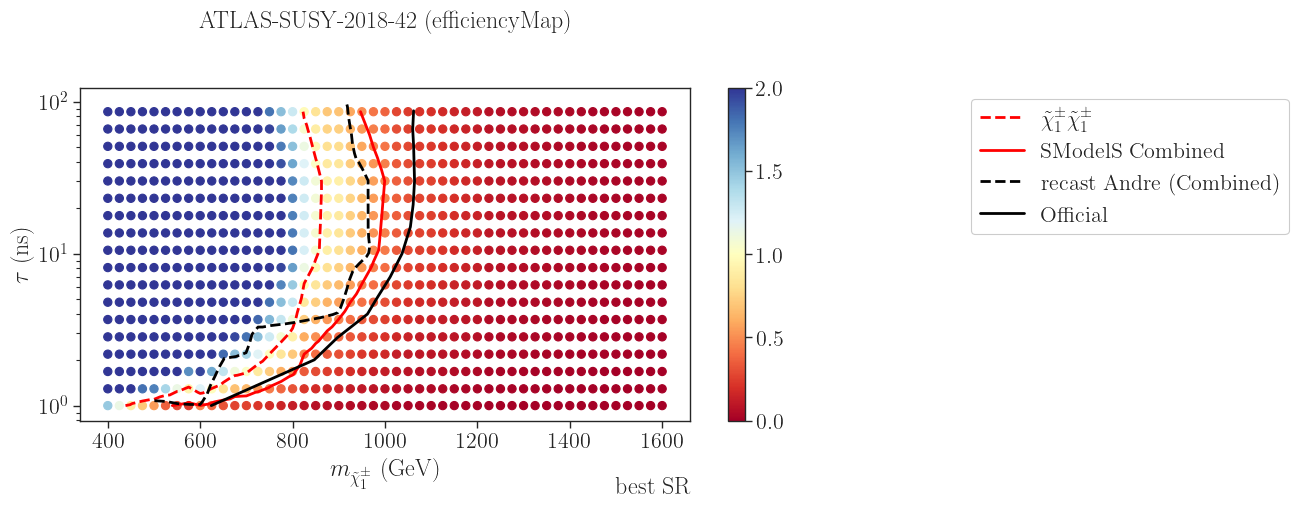

In [10]:
fig = plt.figure(figsize=(20,6))
plt.scatter(x_C1C1,y_C1C1,c=rValues_C1C1,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
plt.plot(excCurve_C1C1[1.0][0][:,0],excCurve_C1C1[1.0][0][:,1],
         label=r'$\tilde\chi_1^\pm \tilde\chi_1^\pm$',
         linewidth=2,linestyle='--',color='red')
plt.plot(excCurve_Comb[1.0][0][:,0],excCurve_Comb[1.0][0][:,1],
         label='SModelS Combined',
         linewidth=2,linestyle='-',color='red')
plt.plot(mass_array,lifetime_array, label='recast Andre (Combined)', linewidth=2,linestyle='--',color='black')
plt.plot(x_off,y_off,label='Official',linewidth=2,linestyle='-',color='black')
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\tilde\chi_1^\pm}$ (GeV)')
plt.yscale('log')
#plt.title(r'$\tilde\chi_1^\pm \tilde\chi_1^\mp$',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=1.0,loc='upper right',bbox_to_anchor=(2, 1))
# Add text above the plot in the middle
plt.text(0.5, 1.2, 'ATLAS-SUSY-2018-42 (efficiencyMap)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# Add text at the bottom right
plt.text(1, -0.2, 'best SR', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes)
plt.colorbar()
plt.tight_layout()
plt.savefig('TDTM1F.png')
#plt.show()

/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/2072631100.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x_C1N1,y_C1N1,c=rValues_C1N1,s=35,cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)
/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/2072631100.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


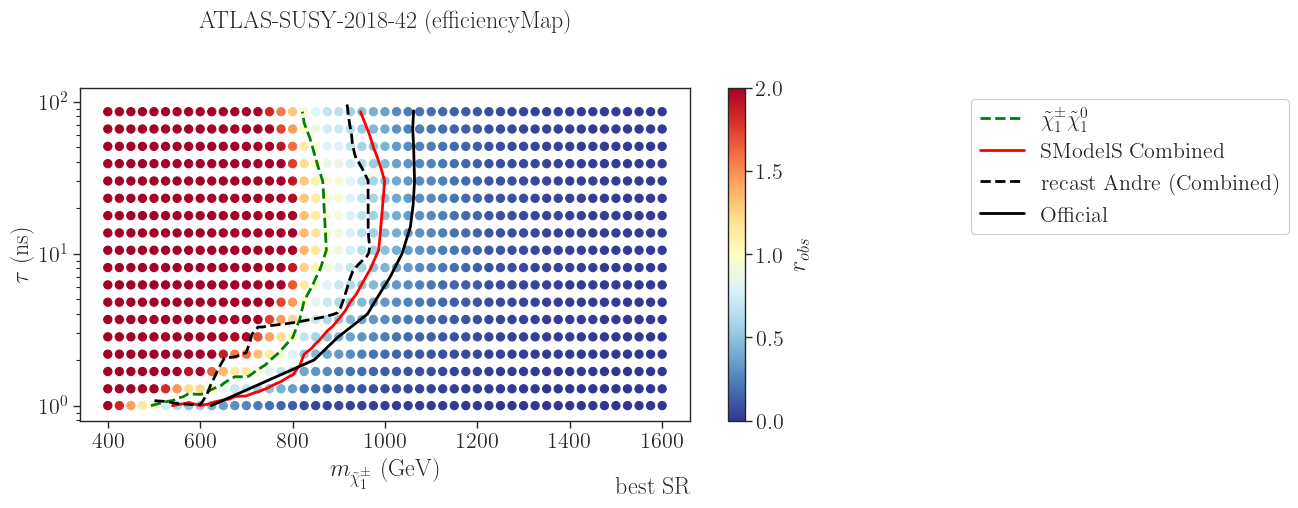

In [11]:
fig = plt.figure(figsize=(20,6))
plt.scatter(x_C1N1,y_C1N1,c=rValues_C1N1,s=35,cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)
plt.plot(excCurve_C1N1[1.0][0][:,0],excCurve_C1N1[1.0][0][:,1],
         label=r'$\tilde\chi_1^\pm \tilde\chi_1^0$',
         linewidth=2,linestyle='--',color='g')
plt.plot(excCurve_Comb[1.0][0][:,0],excCurve_Comb[1.0][0][:,1],
         label='SModelS Combined',
         linewidth=2,linestyle='-',color='red')
plt.plot(mass_array,lifetime_array, label='recast Andre (Combined)', linewidth=2,linestyle='--',color='black')
plt.plot(x_off,y_off,label='Official',linewidth=2,linestyle='-',color='black')
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\tilde\chi_1^\pm}$ (GeV)')
plt.yscale('log')
#plt.title(r'$\tilde\chi_1^\pm \tilde\chi_1^0$',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=1.0,loc='upper right',bbox_to_anchor=(2, 1))
# Add text above the plot in the middle
plt.text(0.5, 1.2, 'ATLAS-SUSY-2018-42 (efficiencyMap)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# Add text at the bottom right
plt.text(1, -0.2, 'best SR', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes)
plt.colorbar(label=r'$r_{obs}$')
plt.tight_layout()
plt.savefig('TDTM2F.png')
#plt.show()

/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/2115099462.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x_Comb,y_Comb,c=rValues_Comb,s=35,cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)
/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/2115099462.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


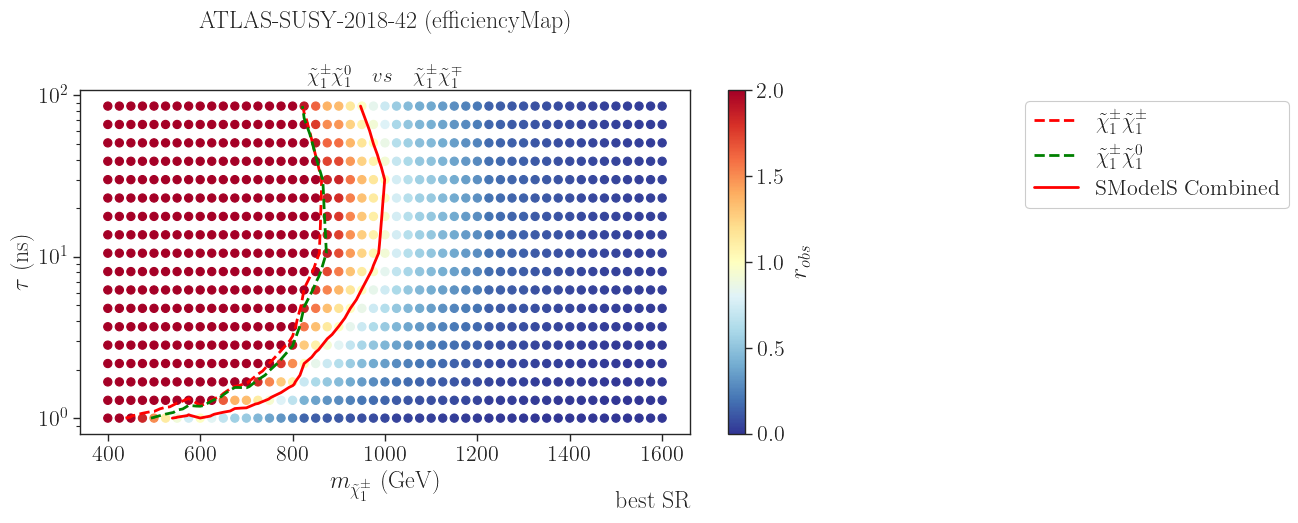

In [12]:
fig = plt.figure(figsize=(20,6))
plt.scatter(x_Comb,y_Comb,c=rValues_Comb,s=35,cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)
plt.plot(excCurve_C1C1[1.0][0][:,0],excCurve_C1C1[1.0][0][:,1],
         label=r'$\tilde\chi_1^\pm \tilde\chi_1^\pm$',
         linewidth=2,linestyle='--',color='red')
plt.plot(excCurve_C1N1[1.0][0][:,0],excCurve_C1N1[1.0][0][:,1],
         label=r'$\tilde\chi_1^\pm \tilde\chi_1^0$',
         linewidth=2,linestyle='--',color='g')
plt.plot(excCurve_Comb[1.0][0][:,0],excCurve_Comb[1.0][0][:,1],
         label='SModelS Combined',
         linewidth=2,linestyle='-',color='red')
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\tilde\chi_1^\pm}$ (GeV)')
plt.yscale('log')
plt.title(r'$\tilde\chi_1^\pm \tilde\chi_1^0 \quad vs \quad \tilde\chi_1^\pm \tilde\chi_1^\mp$',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=1.0,loc='upper right',bbox_to_anchor=(2, 1))
# Add text above the plot in the middle
plt.text(0.5, 1.2, 'ATLAS-SUSY-2018-42 (efficiencyMap)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# Add text at the bottom right
plt.text(1, -0.2, 'best SR', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes)
plt.colorbar(label=r'$r_{obs}$')
plt.tight_layout()
plt.savefig('TDTM1FvsTDTM2F.png')
#plt.show()

/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/3423541.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x_Comb,y_Comb,c=rValues_Comb,s=35,cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)
/var/folders/vm/rx9z7kn56yv6hvpfb9yts7vh0000gn/T/ipykernel_14793/3423541.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


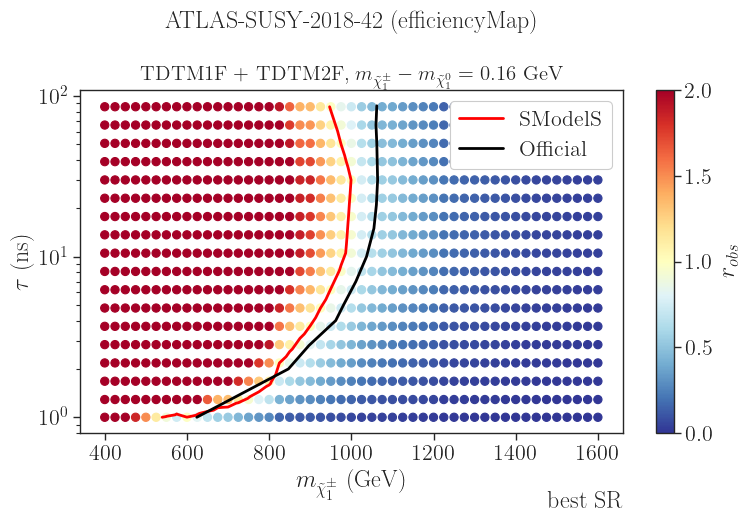

In [13]:
fig = plt.figure(figsize=(8,6))
plt.scatter(x_Comb,y_Comb,c=rValues_Comb,s=35,cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)
plt.plot(excCurve_Comb[1.0][0][:,0],excCurve_Comb[1.0][0][:,1],
         label='SModelS',
         linewidth=2,linestyle='-',color='red')
#plt.plot(mass_array,lifetime_array, label='recast Andre (Combined)', linewidth=2,linestyle='--',color='black')
plt.plot(x_off,y_off,label='Official',linewidth=2,linestyle='-',color='black')
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\tilde\chi_1^\pm}$ (GeV)')
plt.yscale('log')
#plt.title(r'$\tilde\chi_1^\pm \tilde\chi_1^0 +  \tilde\chi_1^\pm \tilde\chi_1^\mp$',fontsize=15)
plt.title(r'TDTM1F + TDTM2F, $m_{\tilde\chi_1^\pm} - m_{\tilde\chi_1^0} = 0.16$ GeV',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=1.0,loc='upper right')
plt.colorbar(label=r'$r_{obs}$')
#plt.ylim(min(y_Comb),100)
# Add text above the plot in the middle
plt.text(0.5, 1.2, 'ATLAS-SUSY-2018-42 (efficiencyMap)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# Add text at the bottom right
plt.text(1, -0.2, 'best SR', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig('TDTM1F-TDTM2F.png')
plt.show()